In [1]:
import pandas as pd
import numpy as np
from environment import Environment
from pandas.tseries.offsets import MonthEnd
import instrument
from portfolio import Portfolio
from risk_parity import RiskParity
from copy import copy, deepcopy

%load_ext autoreload
%autoreload 2

In [2]:
from historical import HistoricalData
from pandas._libs.tslibs.timestamps import Timestamp, Timedelta

path = "data\\"
env_df = pd.read_csv(path + "Consolidated.csv", header = [0,1], index_col=[0])
targets_df = pd.read_csv(path + "Targets.csv", index_col=[0])
features_df = pd.read_csv(path + "Features.csv", header = [0,1], index_col=[0])
exps = pd.read_csv('data\\ETF_info.csv', index_col=0).loc[env_df[['EQ', 'EM', 'RE', 'FI']].columns.droplevel(), 'Expense Ratio'].astype(float)
data = HistoricalData(env_df, features_df, targets_df)

date = Timestamp('2014-03-01') + MonthEnd(0)
date_end = date + MonthEnd(62)
env_now = Environment(*data.get_env_args(date))
rp = RiskParity(data)


### Initializing stuff

In [3]:
usd = 200000/env_now.fx['CAD']
w_dict = rp.get_weights_ac(date, asset_classes=np.array(['FI', 'RE', 'EM']))
pos_dict = Portfolio.weights_to_pos(w_dict, env_now, usd)
pos_dict = Portfolio.etf_dict_from_names(pos_dict)
icash = instrument.Cash('USD')
pos_dict[icash] = 0

In [4]:
my_pf = Portfolio(pos_dict)
etf_w = 0.98
etf_total_val= my_pf.calc_value(env_now)*etf_w
opt_total_val = my_pf.calc_value(env_now)*(1-etf_w)

my_pf.rebalance(env_now, Portfolio.weights_to_pos(w_dict, env_now, etf_total_val), exps, time_past=0)


C = 1 + 0.02
K1 = C - 0.03
K2 = C
K3 = C + 0.03
ttm=2

specs = [{'name':'SPY Call 1', 'ccy':'USD', 'is_call':1, 'ul':'SPY US Equity'},
         {'name':'SPY Call 2', 'ccy':'USD', 'is_call':1, 'ul':'SPY US Equity'},
         {'name':'SPY Call 3', 'ccy':'USD', 'is_call':1, 'ul':'SPY US Equity'}
         ]

cost = Portfolio.get_opt_strategy_price(env_now, specs, [1, -2, 1], [K1,K2,K3], ttm=ttm)
nopt = opt_total_val/cost
ofee = my_pf.buy_options(env_now, specs, [nopt, -nopt*2, nopt], [K1,K2,K3], ttm=ttm)

last_pf_val = my_pf.calc_value(env_now)
last_etf_val = my_pf.get_eq_value(env_now)

last_eq_val = my_pf.get_names_value(env_now, env_df['EQ'].columns)
last_fi_val = my_pf.get_names_value(env_now, env_df['FI'].columns)
last_re_val = my_pf.get_names_value(env_now, env_df['RE'].columns)
last_em_val = my_pf.get_names_value(env_now, env_df['EM'].columns)

last_opt_val = my_pf.get_options_value(env_now)



### Set up performance df

In [5]:
perf_df = pd.DataFrame(index = pd.date_range(start=date, end=date_end, freq='M'))
perf_df['USD Value'] = 0
perf_df['CAD Value'] = 0
perf_df['PNL'] = 0
perf_df['Post-fee PNL'] = np.nan
perf_df['ETF PNL'] = np.nan

perf_df['EQ PNL'] = np.nan
perf_df['FI PNL'] = np.nan
perf_df['EM PNL'] = np.nan
perf_df['RE PNL'] = np.nan

perf_df['Option PNL'] = np.nan
perf_df['Delta PNL'] = np.nan
perf_df['Vega PNL'] = np.nan
perf_df['Theta PNL'] = np.nan
perf_df['Rho PNL'] = np.nan
perf_df['Unexplained PNL'] = np.nan

perf_df['Return'] = 0
perf_df['Post-fee Return'] = np.nan
perf_df['ETF Return'] = np.nan

perf_df['EQ Return'] = np.nan
perf_df['FI Return'] = np.nan
perf_df['EM Return'] = np.nan
perf_df['RE Return'] = np.nan

perf_df['Option Return'] = np.nan
perf_df['Delta Return'] = np.nan
perf_df['Vega Return'] = np.nan
perf_df['Theta Return'] = np.nan
perf_df['Rho Return'] = np.nan
perf_df['Unexplained Return'] = np.nan

perf_df['Injection'] = 0
perf_df['FX'] = env_now.fx['CAD']
perf_df['Option Fees'] = ofee
perf_df['ETF Fees'] = 0
perf_df['ETF Expenses'] = 0

perf_df['Total Fees'] = 0
perf_df['Percentage Fees'] = 0



### Run sim/backtest

In [6]:
perf_df.loc[date, 'USD Value'] = my_pf.calc_value(env_now)
perf_df.loc[date, 'CAD Value'] = my_pf.calc_value(env_now, ccy='CAD')
perf_df.loc[date, 'Return'] = np.nan
perf_df.loc[date, 'PNL'] = np.nan

while date < date_end:
    
    date = date + MonthEnd(1)
    env_before = deepcopy(env_now)
    env_now = Environment(*data.get_env_args(date))
    
    #if env_now.surfaces['SPY US Equity'].matrix[1,5] > 0.20:
    #    # print(date, ": high vol of {:.2f}".format(env_now.surfaces['SPY US Equity'].matrix[1,5]))
    #    etf_w = 1
    #else:
    #    etf_w = 0.98
    
    new_pf_val = my_pf.calc_value(env_now)
    new_etf_val = my_pf.get_eq_value(env_now)
    new_opt_val = my_pf.get_options_value(env_now)
    new_eq_val = my_pf.get_names_value(env_now, env_df['EQ'].columns)
    new_fi_val = my_pf.get_names_value(env_now, env_df['FI'].columns)
    new_re_val = my_pf.get_names_value(env_now, env_df['RE'].columns)
    new_em_val = my_pf.get_names_value(env_now, env_df['EM'].columns)
    
    w_dict = rp.get_weights_ac(date, asset_classes=np.array(['FI', 'RE', 'EM']))
    
    
    etf_total_val= my_pf.calc_value(env_now)*etf_w
    opt_total_val = my_pf.calc_value(env_now)*(1-etf_w)
    

    perf_df.loc[date, 'FX'] = env_now.fx['CAD']
    
    if (date.month == 8) or (date.month == 2):
        my_pf.pf_units[my_pf.get_cash('USD')] += 20000/env_now.fx['CAD']
        perf_df.loc[date, 'Injection'] = 20000/env_now.fx['CAD']
        
    
    
    perf_df.loc[date, 'PNL'] = new_pf_val - last_pf_val
    perf_df.loc[date, 'ETF PNL'] = new_etf_val - last_etf_val
    perf_df.loc[date, 'Option PNL'] = new_opt_val - last_opt_val
    
    attribs = my_pf.get_pnl_attr(env_before, env_now)
    perf_df.loc[date, 'Delta PNL'] = attribs['delta']
    perf_df.loc[date, 'Vega PNL'] = attribs['vega']
    perf_df.loc[date, 'Theta PNL'] = attribs['theta']
    perf_df.loc[date, 'Rho PNL'] = attribs['rho']
    perf_df.loc[date, 'Unexplained PNL'] = perf_df.loc[date, 'Option PNL'] -\
            attribs['delta'] - attribs['vega'] - attribs['theta'] - attribs['rho']
    
    perf_df.loc[date, 'EQ PNL'] = new_eq_val - last_eq_val
    perf_df.loc[date, 'FI PNL'] = new_fi_val - last_fi_val
    perf_df.loc[date, 'EM PNL'] = new_em_val - last_em_val
    perf_df.loc[date, 'RE PNL'] = new_re_val - last_re_val
    
    perf_df.loc[date, 'Return'] = (new_pf_val - last_pf_val)/last_pf_val
    perf_df.loc[date, 'ETF Return'] = (new_etf_val - last_etf_val)/last_pf_val
    perf_df.loc[date, 'Option Return'] = (new_opt_val - last_opt_val)/last_pf_val
    perf_df.loc[date, 'Delta Return'] = attribs['delta']/last_pf_val
    perf_df.loc[date, 'Vega Return'] = attribs['vega']/last_pf_val
    perf_df.loc[date, 'Theta Return'] = attribs['theta']/last_pf_val
    perf_df.loc[date, 'Rho Return'] = attribs['rho']/last_pf_val
    perf_df.loc[date, 'Unexplained Return'] = perf_df.loc[date, 'Unexplained PNL']/last_pf_val
    
    perf_df.loc[date, 'EQ Return'] = (new_eq_val - last_eq_val)/last_pf_val
    perf_df.loc[date, 'FI Return'] = (new_fi_val - last_fi_val)/last_pf_val
    perf_df.loc[date, 'EM Return'] = (new_em_val - last_em_val)/last_pf_val
    perf_df.loc[date, 'RE Return'] = (new_re_val - last_re_val)/last_pf_val
    
    
    efee, eexps = my_pf.rebalance(env_now, Portfolio.weights_to_pos(w_dict, env_now, etf_total_val), exps)
    ofee = my_pf.sell_options(env_now)
    
    # re-buy options
    
    cost = Portfolio.get_opt_strategy_price(env_now, specs, [1, -2, 1], [K1,K2,K3], ttm=ttm)
    nopt = opt_total_val/cost    
    ofee += my_pf.buy_options(env_now, specs, [nopt, -nopt*2, nopt], [K1,K2,K3], ttm=ttm)
    
    # record post-rebalancing (next month starting) portf value
    perf_df.loc[date, 'USD Value'] = my_pf.calc_value(env_now)
    perf_df.loc[date, 'CAD Value'] = my_pf.calc_value(env_now, ccy='CAD')
    perf_df.loc[date, 'Post-fee Return'] = (perf_df.loc[date, 'USD Value'] - perf_df.loc[date, 'Injection'])/perf_df.loc[date + MonthEnd(-1), 'USD Value'] - 1
    perf_df.loc[date, 'Post-fee PNL'] = (perf_df.loc[date, 'USD Value'] - perf_df.loc[date, 'Injection']) - perf_df.loc[date + MonthEnd(-1), 'USD Value']
    
    # record fees
    perf_df.loc[date, 'ETF Fees'] = efee
    perf_df.loc[date, 'ETF Expenses'] = eexps
    perf_df.loc[date, 'Option Fees'] = ofee
    perf_df.loc[date, 'Total Fees'] = ofee + eexps + efee
    perf_df.loc[date, 'Percentage Fees'] = (ofee + eexps + efee)/last_pf_val
    
    # find post fee returns
    
    
    # record post rebalancing values for opts and eqs
    last_pf_val = my_pf.calc_value(env_now)
    last_etf_val = my_pf.get_eq_value(env_now)
    last_opt_val = my_pf.get_options_value(env_now)
    last_eq_val = my_pf.get_names_value(env_now, env_df['EQ'].columns)
    last_fi_val = my_pf.get_names_value(env_now, env_df['FI'].columns)
    last_re_val = my_pf.get_names_value(env_now, env_df['RE'].columns)
    last_em_val = my_pf.get_names_value(env_now, env_df['EM'].columns)
    
    #####
    # my_pf.get_forw_risk(env_now: Environment, dist: Distribution, N=1000) vector of 1000 simulated forward pnls
    # -> self.emp_dist = xxxx
    # -> my_pf.calc_var()
    # -->   return -np.percentile(self.emp_dist, 5)
    # -> my_pf.calc_cvar()
    
    
    #####
    

In [7]:
my_pf.get_options()[0].get_greeks(env_now)

{'delta': 0.5752521451668763,
 'gamma': 0.01573381241576674,
 'vega': 59.586495541189265,
 'theta': -29.51746307746316,
 'rho': 33.92496903814483}

In [8]:
sub_df = perf_df[['Option PNL', 'Delta PNL', 'Vega PNL', 'Theta PNL', 'Rho PNL', 'Unexplained PNL']]
sub_df.loc[sub_df.index, 'UL'] = env_df['EQ'].loc[sub_df.index, 'SPY US Equity']
sub_df

c:\users\vladislav\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\vladislav\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:366: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(new_indexer, value)
c:\users\vladislav\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats 

,Option PNL,Delta PNL,Vega PNL,Theta PNL,Rho PNL,Unexplained PNL,UL
2014-03-31,NaN,NaN,NaN,NaN,NaN,NaN,229.8109
2014-04-30,2411.700062,435.435999,201.389970,859.942420,0.000000,914.931673,231.4084
2014-05-31,6411.938944,1467.345743,1815.578847,874.114600,1.056344,2253.843411,236.7786
2014-06-30,5880.344984,1417.710158,1546.075519,825.163486,-1.158988,2092.554809,241.6641
2014-07-31,-1190.663813,-1202.724721,-1576.899623,822.835270,0.000000,766.125261,238.4168
2014-08-31,8574.578462,2238.185149,4688.752402,993.313589,0.000000,654.327321,247.8255
2014-09-30,-1328.084641,-1218.369118,-1726.901403,967.892745,0.000000,649.293135,244.4077
2014-10-31,8014.343293,1765.349019,3030.544205,1181.637223,0.000000,2036.812845,250.1637
2014-11-30,8864.241609,1982.259665,4078.400607,1156.551407,3.649996,1643.379934,257.0362
2014-12-31,-215.518379,-216.844776,-1652.706407,1017.592233,-1.348717,637.789289,256.3782


### Evaluate performance

In [9]:
irr_values = np.array([-perf_df['USD Value'].iloc[0]] + (-perf_df['Injection'].values).tolist())
irr_values[-1] += perf_df['USD Value'].iloc[-1]
np.irr(irr_values)*12

0.21433130744900097

In [10]:
ret_vec =  perf_df['Return'].dropna().values
ret_vec = perf_df['Option Return'].dropna().values


m = ret_vec.mean()*12
s = ret_vec.std()*np.sqrt(12)
var = -np.percentile(ret_vec, 5)*np.sqrt(12)
cvar = -ret_vec[ret_vec<np.percentile(ret_vec, 5)].mean()*np.sqrt(12)
print("Mean: {:.1f}%\nStd: {:.1f}%\nVaR: {:.1f}%\nCVaR: {:.1f}%".format(m*100, s*100, var*100, cvar*100))
print("Sharpe: {:.1f}".format(m/s))

Mean: 19.1%
Std: 6.7%
VaR: 4.7%
CVaR: 5.0%
Sharpe: 2.9


In [11]:
import matplotlib.pyplot as plt
perf_df['Return'].dropna().hist()
plt.show()

<Figure size 640x480 with 1 Axes>

In [12]:
print(perf_df['ETF Return'].std()*np.sqrt(12))
print(perf_df['ETF Return'].mean()*12)

0.05582663959917884
0.049253727308538275


In [13]:
print(perf_df['Option Return'].std()*np.sqrt(12))
print(perf_df['Option Return'].mean()*12)

0.0675093814263977
0.19084999326513122


In [ ]:
my_pf.get_forward_pnl(env_now, data, 1000)

### Risk stuff for current portfolio

In [22]:
var_loss = my_pf.calc_var()/my_pf.calc_value(env_now)*100
cvar_loss = my_pf.calc_es()/my_pf.calc_value(env_now)*100
print("Est. VaR loss: {:.2f}%".format(var_loss))
print("Est. CVaR loss: {:.2f}%".format(cvar_loss))

Est. VaR loss: 3.20%
Est. CVaR loss: 4.13%


(array([  9.,  35.,  88., 162., 207., 180., 159., 110.,  45.,   5.]),
 array([-56567.43743282, -43740.13127072, -30912.82510861, -18085.51894651,
         -5258.2127844 ,   7569.0933777 ,  20396.3995398 ,  33223.70570191,
         46051.01186401,  58878.31802612,  71705.62418822]),
 <a list of 10 Patch objects>)

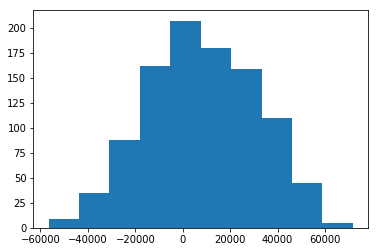

In [15]:
plt.hist(my_pf.emp_dist)

In [16]:
(perf_df['PNL'] * my_pf.calc_value(env_now) / perf_df['USD Value']).sort_values()[0:5]

2018-02-28   -29736.127496
2014-09-30   -29720.773000
2015-08-31   -28487.885897
2018-10-31   -24613.250710
2015-06-30   -18764.400919
dtype: float64

In [17]:
greeks = my_pf.calc_opt_greeks(env_now)

In [18]:
print(greeks['delta']*env_now.prices['SPY US Equity']*0.01)
print(0.5*greeks['gamma']*(env_now.prices['SPY US Equity']*0.01)**2)
print(greeks['vega']*0.01)
print(greeks['theta']/12)

1708.7658909470974
-89.64282191255876
-776.6528670115815
4030.617481308407
